In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from model import NGramModel

%matplotlib inline

N_EMB = 10
N_HIDDEN = 200
BLOCK_SIZE = 3  # the n in n-gram
VOCAB_SIZE = 27  # num letters in alphabet + spec. char.
NUM_ITERATIONS = 200000
BATCH_SIZE = 32

# MLP Neural Network for 3-gram prediction
- Based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

## Lessons learned
### Layer initialization for logit output
There are worse and better ways to initialize a neural network. In the case of this model where the final output layer is mapping from the hidden layer to the output (which is the 26+1 characters of the alphabet) the model should a priori not have any preference for which character it predicts, given a certain n-gram.

Note that the final layer in this model predicts logits, i.e. not probabilities but rather 
$$\text{logit}(p) = \ln \frac{p}{1 - p}$$
where $p$ is the probability, given a logit. This means to arrive at probabilities we need to exponentiate and normalize:
$$p = \frac{e^{\text{logit}(p)}}{1 + e^{\text{logit}(p)}}$$
If the weights in the output layer are initialized randomly with large (depending on the exact context) numbers, then small deviations can lead to massive differences in the probabilities since exponentiating with exponent 2 or 8 (for example) makes a huge difference. 

An ad hoc solution to this is to simply scale the initial model weights by some factor smaller than 1 and calculate the model loss after one forward pass to see whether the loss has noticeably reduced.

When done right, this removes the 'hockey stick' nature of the plot of the training loss which occurs when the model first has to 'battle' the bad initialization.

### Dead neurons due to tanh
(See a plot of $\tanh(x)$ below)

Whenever we have a non-linear layer (such as the hidden layer in this model) with a tanh nonlinearity (and also other ones) we can run into the problem of dead neurons.

Remember that the derivative of the tanh is as follows:

$$\frac{d \tanh(x)}{d x} = 1 - \tanh(x)^2$$

Note that if $tanh(x)$ is either 1 or -1, the derivative will be zero (as can be seen in the plot below by the tails of the tanh flattening out towards plus and minus infinity).

Remember also that during backpropagation the gradient that is passed on is the incoming gradient times the local gradient. This means if the weights of the tanh layer are initialized in such a way so as to produce values close to 1 or -1 for a whole neuron, it will never learn as its gradient will always be zero. 

An ad hoc solution again is to simply squash the layer weights until the histogram of the output after the first training iteration shows that the vast majority of outputs is far away from -1 and 1.

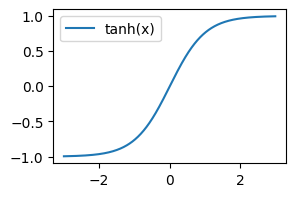

In [50]:
plt.figure(figsize=(3, 2))
x_min, x_max, step_size = -3, 3, 0.01
x = torch.arange(x_min, x_max, step=step_size).tolist()
tanh_of_x = torch.arange(x_min, x_max, step=step_size).tanh().tolist()
plt.plot(x, tanh_of_x, label="tanh(x)")
plt.legend()

### Systematic ways of picking useful initialization
- https://pytorch.org/docs/stable/nn.init.html (Kaiming)
- https://arxiv.org/abs/1502.01852

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
# s to i maps characters to the index in the N tensor below
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0
i_to_s = {i: s for s, i in s_to_i.items()}  # invert s to i mapping
print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# create training set of all bigrams
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + ".":
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
model = NGramModel(
    n_gram_size=BLOCK_SIZE,
    vocab_size=VOCAB_SIZE,
    embedding_size=N_EMB,
    hidden_layer_size=N_HIDDEN,
)

Total number of parameters: 11897


In [28]:
model.train(
    X_training=Xtr,
    Y_training=Ytr,
    X_validation=Xval,
    Y_validation=Yval,
    num_iterations=100000,
    learning_rate=0.01,
    batch_size=512,
)

Iteration 700000 loss: 1.9938
Iteration 710000 loss: 1.9424
Iteration 720000 loss: 2.0986
Iteration 730000 loss: 2.0903
Iteration 740000 loss: 1.9961
Iteration 750000 loss: 1.9599
Iteration 760000 loss: 1.9946
Iteration 770000 loss: 2.0680
Iteration 780000 loss: 1.9055
Iteration 790000 loss: 1.9318
Loss on the final iteration: 1.9998
Validation loss on the final iteration: 2.0982


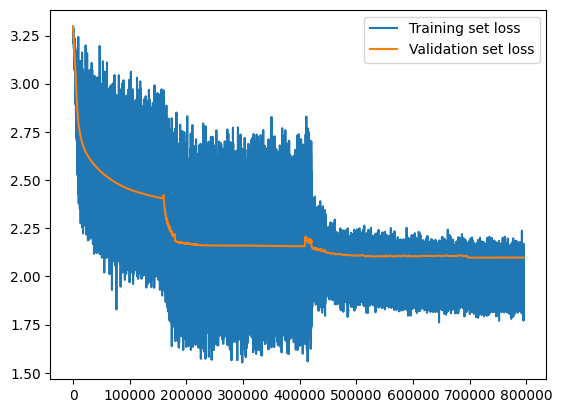

In [29]:
plt.plot(model.iterations, model.losses, label="Training set loss")
plt.plot(
    model.validation_iterations, model.validation_losses, label="Validation set loss"
)
plt.legend()

In [30]:
g = torch.Generator()  # .manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        logits = model.get_logits(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(i_to_s[i] for i in out))

cybianahili.
hyne.
daily.
aadie.
taimeryk.
audiel.
lilani.
tahmor.
marbar.
liannie.
arni.
sanibara.
hendancy.
evaanisha.
mohana.
ifer.
abvaliyah.
ana.
gustiannahedu.
jaguardonon.
